# Speeding up iterations in Python
> This is a rewrite of an orinal work by **Maximilian STRAUß**: find article [here](https://towardsdatascience.com/speeding-up-python-code-fast-filtering-and-slow-loops-8e11a09a9c2f)

When scripting *python*, we often use loops, iterators or generators. This document will be used to create test scenarios and figure out what method is the most efficient for each use-case.<br>
The approach here is to give more thought about code optimization and find ways to speed up the computation time in Python using *pure Python*, `numpy`, `pandas`.

## Filtering datasets
We will create a dataset of a 2-dimensional points in space.<br>
Let's imagine we want to extract all points that are in a rectangle between `x = 0.2` `y = 0.4` and `x = 0.4` `y = 0.6`.

In [1]:
# Creating the dataset
import numpy as np
import matplotlib.pyplot as plt

def random_array(size, dim=3):
    """Generates a random array of size = size and dimension = dim
    """
    return np.random.rand(int(size), dim)

Now let's check all the options we have available to us for actually filtering the data:
- for loop using numpy
- for loop in pure python
- list comprehension
- map
- filter

### Loop using Numpy

In [2]:
# Generate a random array of size 1e5
array = random_array(1e5)

In [3]:
def loop(array):
    """Takes a numpy array and isolates all points that are within [0.2, 0.4]
    for the first column and between [0.4, 0.6] for the second column by
    looping through every point.
    """
    filtered_list = []
    
    for i in range(len(array)):
        # Check if the point is within the rectangle
        if ((array[i][0] >= 0.2)
            and (array[i][1] >= 0.4)
            and (array[i][0] <= 0.4)
            and (array[i][1] <= 0.6)):
            filtered_list.append(array[i])
    return np.array(filtered_list)

Testing the results:

In [4]:
# Measure code execution with inline magic (Jupyter Notebook)
print('Loop with Numpy:\t', end='')
%timeit loop(array)

Loop with Numpy:	79.4 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


On the tested machine we have ~80 ms execution

**! NOTE !**<br>
When combining expression we use `and` instead of `&` because the former stops the evaluation if the first condition is `False` whereas the latter will evaluate all the conditions regardless of their *truelyness*.


#### Plot the results

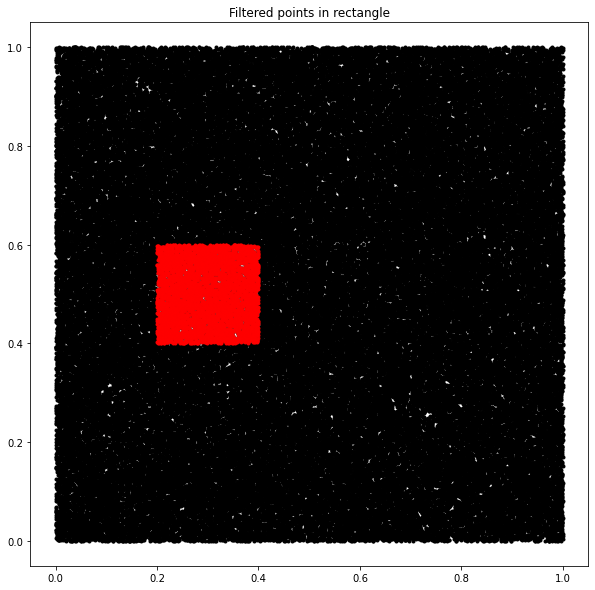

In [5]:
# We need to filter the array:
filtered_array = loop(array)

%matplotlib inline
plt.figure(figsize=(10, 10))
plt.title('Filtered points in rectangle')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(filtered_array[:, 0], filtered_array[:, 1], 'r.')
plt.show()

### Loop in pure Python

Numpy is cool to interact wit large n-dimensional datasets. However, it is an addtional module, so there should be some overhead using its objects. Plus, in this case we do not use any mathematical operations where we could benefit from numpy's vectorization.

This is why it is interesting to implement the same loop but in pure Python:

In [6]:
# First let's convert our Numpy Dataset into a 'pure' Python list of tuples
python_list = list(map(tuple, array))

In [7]:
def python_loop(random_list):
    """Takes a list of tuples and isolates all points that are within [0.2, 0.4]
    for the first dimension and between [0.4,0.6] for the second dimension.
    """
    filtered_list = []
    
    for i in range(len(random_list)):
        if ((random_list[i][0] >= 0.2)
            and (random_list[i][1] >= 0.4)
            and (random_list[i][0] <= 0.4)
            and (random_list[i][1] <= 0.6)):
            filtered_list.append(random_list[i])
    return filtered_list

In [8]:
# Measure code execution with inline magic (Jupyter Notebook)
print('Python loop:\t', end='')
%timeit python_loop(python_list)

Python loop:	25.3 ms ± 665 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


On the tested machine we have ~25 ms execution

***This shows how much the performance can decrease when we use a highly optimized package for simple tasks !***

### List comprehension
Since the *pure Python* appoach was faster, we can still improve it with *List Comprehension* right ?<br>
After all, list comprehensions usually perform better than loops since they dont need to call the `append( )` function at each iteration.

Let's find out.

In [9]:
def list_comprehension(tuple_list):
    """Takes a list of tuples and isolates all points that are within [0.2, 0.4]
    for the first dimension and between [0.4,0.6] for the second dimension
    using a list comprehension.
    """
    filtered_list = [_ for _ in tuple_list if (_[0] >= 0.2) and (_[1] >= 0.4) and (_[0] <= 0.4) and (_[1] <= 0.6)]
    return filtered_list

In [10]:
# Measure code execution with inline magic (Jupyter Notebook)
print('List comprehension:\t', end='')
%timeit list_comprehension(python_list)

List comprehension:	19.1 ms ± 535 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


On the tested machine we have ~20 ms execution

Yeah! slightly faster.

### Map function

In [11]:
def map_fctn(_):
    """Takes a tuple and returns it if the first value is within [0.2,0.4]
    while the second value is between [0.4,0.6].
    """
    if (_[0] >= 0.2) and (_[1] >= 0.4) and (_[0] <= 0.4) and (_[1] <= 0.6):
        return _

In [12]:
# Measure code execution with inline magic (Jupyter Notebook)
print('Map:\t\t\t', end='')
%timeit list(filter(map_fctn, python_list))

Map:			23.3 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Filter function

In [13]:
def filter_fctn(_):
    """Takes a tuple and returns True if the first value is within [0.2,0.4]
    while the second value is between [0.4,0.6].
    """
    return (_[0] >= 0.2) and (_[1] >= 0.4) and (_[0] <= 0.4) and (_[1] <= 0.6)

In [14]:
# Measure code execution with inline magic (Jupyter Notebook)
print('Filter:\t\t\t', end='')
%timeit list(filter(filter_fctn, python_list))

Filter:			24 ms ± 319 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


As we can see nor the Map function, nor the Filter function offer a significant speedup compared to the *pure Python* loop.

## Going faster
Is there a way to speed the process up even further than with the list comprehension ?<br>
Well if we go back to *numpy* for a second, we could change our approach to the filtering.

Instead of simply evaluating conditions, we could use ***boolean indexing***. Boolean indexing is a methodology that performs a check column-wise instead of element-wise.

### Boolean indexing

In [15]:
def boolean_index(array):
    """Takes a numpy array and isolates all points that are within [0.2,0.4] for
    the first dimension and between [0.4,0.6] for
    the second dimension by creating a boolean index.
    """
    index = (array[:, 0] >= 0.2) & (array[:, 1] >= 0.4) & (array[:, 0] <= 0.4) & (array[:, 1] <= 0.6)

    return array[index]

In [16]:
# Measure code execution with inline magic (Jupyter Notebook)
print('Boolean index:\t', end='')
%timeit boolean_index(array)

Boolean index:	640 µs ± 6.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


WOW! we left the realm of ms and reached µs ! That's about 50x faster.

### Numba
Now can we go even faster ? Yes we can with tools like `Numba`. [Numba](https://numba.pydata.org/numba-doc/dev/user/5minguide.html) is a *just-in-time compiler* for Python that works best on code that uses Numpy arrays and functions and loops.

> It translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN.

If the functions are correctly set up, i.e. using loops and basic numpy functions, a simple addition of the @njit decorator will flag the function to be compiled in numba and will be rewarded with an increase in speed.

In [17]:
from numba.typed import List
from numba import njit

# Re-write our boolean-index using numba
@njit
def boolean_index_numba(array):
    """
    Takes a numpy array and isolates all points that are within [0.2,0.4] for
    the first dimension and between [0.4,0.6] for the second dimension
    by creating a boolean index. 
    This function will be compiled with numba.
    """
    index = (array[:, 0] >= 0.2) & (array[:,  1] >= 0.4) & (array[:, 0] <= 0.4) & (array[:, 1] <= 0.6)

    return array[index]


# Re-write our Numpy loop using numba
@njit
def loop_numba(array):
    """
    Takes a numpy array and isolates all points that are within [0.2,0.4] for
    the first dimension and between [0.4,0.6] for the second dimension.
    This function will be compiled with numba.
    """
    filtered_list = List()
    for i in range(len(array)):
        if ((array[i][0] >= 0.2)
            and (array[i][1] >= 0.4)
            and (array[i][0] <= 0.4)
            and (array[i][1] <= 0.6)):
            filtered_list.append(array[i])
    return filtered_list

In [18]:
# Measure code execution with inline magic (Jupyter Notebook)
# filtered_list = boolean_index_numba(array)
print('Boolean index with numba:\t', end='')
%timeit boolean_index_numba(array)

# filtered_list = loop_numba(array)
print('Numpy loop with numba:\t\t', end='')
%timeit loop_numba(array)

Boolean index with numba:	324 µs ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy loop with numba:		1.04 ms ± 74.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Wonderfull we have devided our processing time by 2.

What is really interesting with Numba is that our *Numpy loop* code has been optimized from around 80 ms to lest than 1 ms just with this little hack. This goes to show the potential of Numba, even on poolry optimized code.

### Pandas
What about `Pandas`? Let's try it out:

In [19]:
import pandas as pd

df = pd.DataFrame({'x': array[:, 0], 'y': array[:, 1], 'z': array[:, 2]})

# Pandas query
print('Pandas Query:\t\t', end='')
%timeit df.query('x >= 0.2 and x <= 0.4 and y >= 0.4 and y <= 0.6')

# Pandas eval
print('Pandas Eval:\t\t', end='')
%timeit df.eval('x >= 0.2 and x <= 0.4 and y >= 0.4 and y <= 0.6')

# Boolean index
print('Pandas Boolean index:\t', end='')
%timeit df[(df['x'] >= 0.2) & (df['y'] >= 0.4) & (df['x'] <= 0.4) & (df['y'] <= 0.6)]

Pandas Query:		2.2 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Pandas Eval:		1.74 ms ± 30.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Pandas Boolean index:	1.01 ms ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


While testing our `pandas`, we were careful to show all options to show the choice that can be made between code performance, easy interfacing and readable code.<br>
This is why, we compared multiple filtering functions.

We can see that the code is much faster than our initial `python` or `numpy` functions but is still slower than our `numba` code. This is why it can possibly be used for testing but should be optimized afterwards.

## Benchmarking and comparison of the different approaches
We will use the [perfplot](https://github.com/nschloe/perfplot/blob/master/README.md) package for the benchmark.

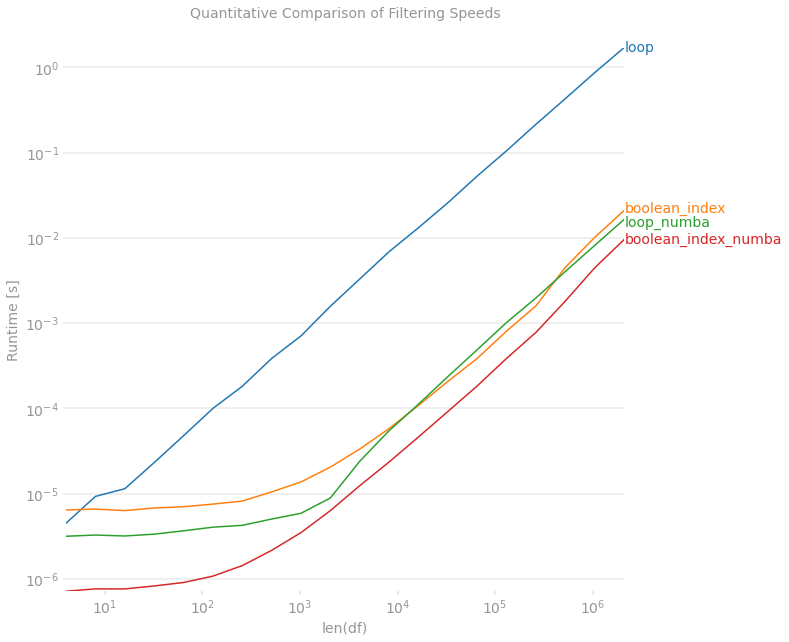

In [20]:
import perfplot

plt.figure(figsize=(10, 10))
plt.title('Quantitative Comparison of Filtering Speeds')
perfplot.show(
    setup=random_array,
    kernels=[loop, boolean_index, loop_numba, boolean_index_numba],
    n_range=[2**k for k in range(2, 22)],
    logx=True,
    logy=True,
    equality_check=False,
    xlabel='len(df)')